# Predicting the promotional offer usage using Machine Learning

The goal of this notebook is to use Starbucks Customer Data <a href="https://www.kaggle.com/ihormuliar/starbucks-customer-data"> (from this kaggle site) </a> to predict if a promotional offer is used or not.

### Problem Definition
> Given various parameters about the customer and offer, can we predict whether or not they will use said offer?

### Data

The originial data "was provided by Starbucks to simulate their customers and transactions to see if there are better approaches to sending customers specific promotional deals."

It was downloaded off Kaggle: https://www.kaggle.com/ihormuliar/starbucks-customer-data

### Evaluation
> We will attempt to predict with an 75% accuracy if a coupon is used, just viewed, or not used at all.

### Features

This data set comes initially in three csv files.
1. The portfolio csv contains information about the promotional offers.
     - id: offer id
    - offer_type: type of offer ie BOGO, discount, informational
    - difficulty: minimum required spend to complete an offer
    - reward: stars given for completing an offer
    - duration: time in days offer was available
    - channels: (list of strings) on the various channels used to send out the promostion
2. profile csv file contained information on the customer profiles
    - age
    - became_member_on
    - gender
    - id: customer id
    - income
3. transcript csv file contained information on the customer interactions with the coupons as well as their transactions
    - event: transaction, offer received, viewed
    - person: customer id
    - time: time in hours since start of an offer
    - value: was a dictionary of strings containing either an offer id and reward or transaction amount depending on the event

**The first step is to load the data and then explore it**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
df_portfolio = pd.read_csv("archive/portfolio.csv")
df_profile = pd.read_csv("archive/profile.csv")
df_transcript = pd.read_csv("archive/transcript.csv")

lets just take a quick glance at the portfolio dataframe

In [3]:
df_portfolio.head()

,Unnamed: 0,reward,channels,difficulty,duration,offer_type,id
0,0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
#this is only because the file already had indexing
df_portfolio.drop("Unnamed: 0", axis=1, inplace=True) 

In [5]:
df_portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [6]:
df_portfolio.dtypes

reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object

In [7]:
df_portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


lets take a look at the profile data frame next

In [8]:
df_profile.head()

,Unnamed: 0,gender,age,id,became_member_on,income
0,0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [9]:
#same issue with double indexing as before
df_profile.drop("Unnamed: 0", axis=1, inplace=True) 

In [10]:
df_profile.head()

,gender,age,id,became_member_on,income
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [11]:
df_profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [12]:
df_profile.shape

(17000, 5)

out of 17,0000 data points we are missing 2175 customers gender and 2175 customers income. We'll drop this after combining the data with our transcript dataframe.

In [13]:
df_transcript.head()

,Unnamed: 0,person,event,value,time
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [14]:
#same issue with double indexing as before
df_transcript.drop("Unnamed: 0", axis=1, inplace=True)

In [15]:
df_transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [16]:
df_transcript.shape, df_transcript.dtypes

((306534, 4), person    object
 event     object
 value     object
 time       int64
 dtype: object)

In [17]:
# getting ready to merge the two data frames on the customer id data point
df_profile.rename(columns={'id':'customer id'}, inplace=True)
df_transcript.rename(columns={'person':'customer id'}, inplace=True)

In [18]:
df = pd.merge(df_transcript, df_profile, on='customer id')
df

,customer id,event,value,time,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,F,75,20170509,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,F,75,20170509,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132,F,75,20170509,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,F,75,20170509,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144,F,75,20170509,100000.0
...,...,...,...,...,...,...,...,...
306529,912b9f623b9e4b4eb99b6dc919f09a93,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,NaN,118,20170926,NaN
306530,912b9f623b9e4b4eb99b6dc919f09a93,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},594,NaN,118,20170926,NaN
306531,3045af4e98794a04a5542d3eac939b1f,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,F,58,20161020,78000.0
306532,3045af4e98794a04a5542d3eac939b1f,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,F,58,20161020,78000.0


In [19]:
# we only are caring about the offers in our case so we will drop the ammounts

In [20]:
len(df[df.event == 'transaction'])

138953

In [21]:
len(df)

306534

In [22]:
df.drop(df[df.event == 'transaction'].index, inplace=True)
df.head()

,customer id,event,value,time,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,F,75,20170509,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,F,75,20170509,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,F,75,20170509,100000.0
5,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,F,75,20170509,100000.0
6,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,F,75,20170509,100000.0


In [23]:
len(df)

167581

In [24]:
306534-138953

167581

In [25]:
# now lets work on incoporating the portfolio data into our dataframe
for s in df['value']:
    for key, value in s.items() :
        print (key)

AttributeError: 'str' object has no attribute 'items'

In [27]:
# instead of this being a list or dictionary this seems to just be a string....
df.dtypes

customer id          object
event                object
value                object
time                  int64
gender               object
age                   int64
became_member_on      int64
income              float64
dtype: object

In [28]:
# okay its definitely a string
df["value"] = df["value"].str.replace("[\{\}\:\'\'\,/.]", "")
df["value"]

0                 offer id 9b98b8c7a33c4b65b9aebfe6a799e6d9
1                 offer id 9b98b8c7a33c4b65b9aebfe6a799e6d9
3         offer_id 9b98b8c7a33c4b65b9aebfe6a799e6d9 rewa...
5                 offer id 5a8bc65990b245e5a138643cd4eb9837
6                 offer id 5a8bc65990b245e5a138643cd4eb9837
                                ...                        
306528    offer_id fafdcd668e3743c1bb461111dcafc2a4 rewa...
306529            offer id 4d5c57ea9a6940dd891ad53e9dbe8da0
306530            offer id 4d5c57ea9a6940dd891ad53e9dbe8da0
306531            offer id 4d5c57ea9a6940dd891ad53e9dbe8da0
306532            offer id 4d5c57ea9a6940dd891ad53e9dbe8da0
Name: value, Length: 167581, dtype: object

In [29]:
df["value"] = df["value"].str.replace("offer id ", "")
df["value"] = df["value"].str.replace("offer_id ", "")

# we will know the reward points once we merge the data together so we can get rid of that
df["value"] = df["value"].str.replace("reward \d+", "")
df["value"] = df["value"].str.strip()
df["value"]

0         9b98b8c7a33c4b65b9aebfe6a799e6d9
1         9b98b8c7a33c4b65b9aebfe6a799e6d9
3         9b98b8c7a33c4b65b9aebfe6a799e6d9
5         5a8bc65990b245e5a138643cd4eb9837
6         5a8bc65990b245e5a138643cd4eb9837
                        ...               
306528    fafdcd668e3743c1bb461111dcafc2a4
306529    4d5c57ea9a6940dd891ad53e9dbe8da0
306530    4d5c57ea9a6940dd891ad53e9dbe8da0
306531    4d5c57ea9a6940dd891ad53e9dbe8da0
306532    4d5c57ea9a6940dd891ad53e9dbe8da0
Name: value, Length: 167581, dtype: object

In [30]:
df["value"].unique()

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '5a8bc65990b245e5a138643cd4eb9837',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '3f207df678b143eea3cee63160fa8bed',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '2298d6c36e964ae4a3e7e9706d1fb8c2'], dtype=object)

In [31]:
len(df["value"].unique())

10

In [32]:
df.head()

,customer id,event,value,time,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,F,75,20170509,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,9b98b8c7a33c4b65b9aebfe6a799e6d9,6,F,75,20170509,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,9b98b8c7a33c4b65b9aebfe6a799e6d9,132,F,75,20170509,100000.0
5,78afa995795e4d85b5d9ceeca43f5fef,offer received,5a8bc65990b245e5a138643cd4eb9837,168,F,75,20170509,100000.0
6,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,5a8bc65990b245e5a138643cd4eb9837,216,F,75,20170509,100000.0


In [33]:
#lets see if this is also a string
df_portfolio['channels'].str.strip()

0           ['email', 'mobile', 'social']
1    ['web', 'email', 'mobile', 'social']
2              ['web', 'email', 'mobile']
3              ['web', 'email', 'mobile']
4                        ['web', 'email']
5    ['web', 'email', 'mobile', 'social']
6    ['web', 'email', 'mobile', 'social']
7           ['email', 'mobile', 'social']
8    ['web', 'email', 'mobile', 'social']
9              ['web', 'email', 'mobile']
Name: channels, dtype: object

In [34]:
# getting ready to merge the two data frames on the customer id data point
df_portfolio.rename(columns={'id': 'value'}, inplace=True)
df = pd.merge(df, df_portfolio, on='value')
df.head()

,customer id,event,value,time,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,F,75,20170509,100000.0,5,"['web', 'email', 'mobile']",5,7,bogo
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,9b98b8c7a33c4b65b9aebfe6a799e6d9,6,F,75,20170509,100000.0,5,"['web', 'email', 'mobile']",5,7,bogo
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,9b98b8c7a33c4b65b9aebfe6a799e6d9,132,F,75,20170509,100000.0,5,"['web', 'email', 'mobile']",5,7,bogo
3,e2127556f4f64592b11af22de27a7932,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,408,M,68,20180426,70000.0,5,"['web', 'email', 'mobile']",5,7,bogo
4,e2127556f4f64592b11af22de27a7932,offer viewed,9b98b8c7a33c4b65b9aebfe6a799e6d9,420,M,68,20180426,70000.0,5,"['web', 'email', 'mobile']",5,7,bogo


In [35]:
df["channels"].unique()

array(["['web', 'email', 'mobile']", "['email', 'mobile', 'social']",
       "['web', 'email', 'mobile', 'social']", "['web', 'email']"],
      dtype=object)

In [36]:
df.isna().sum()

customer id             0
event                   0
value                   0
time                    0
gender              18776
age                     0
became_member_on        0
income              18776
reward                  0
channels                0
difficulty              0
duration                0
offer_type              0
dtype: int64

In [37]:
df.shape

(167581, 13)

In [38]:
167581-18776

148805

In [39]:
# remove rows with missing income and gender
df.dropna(inplace=True)
len(df)

148805

In [40]:
df.isna().sum()

customer id         0
event               0
value               0
time                0
gender              0
age                 0
became_member_on    0
income              0
reward              0
channels            0
difficulty          0
duration            0
offer_type          0
dtype: int64

### All that just to put together the data! and we still have to do other things to it!

In [41]:
# lets do some exploratory data analysis to it
df.event.value_counts()

offer received     66501
offer viewed       49860
offer completed    32444
Name: event, dtype: int64

In [42]:
df.event.value_counts(normalize=True)

offer received     0.446900
offer viewed       0.335069
offer completed    0.218030
Name: event, dtype: float64

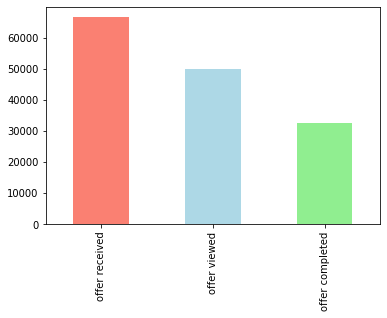

In [43]:
# Plot the value counts with a bar graph just to see it nicer
df.event.value_counts().plot(kind="bar", color=["salmon", "lightblue", 'lightgreen']);

In [44]:
df.gender.value_counts(normalize=True)

M    0.557078
F    0.428205
O    0.014717
Name: gender, dtype: float64

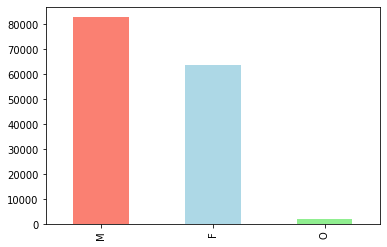

In [45]:
df.gender.value_counts().plot(kind="bar", color=["salmon", "lightblue", 'lightgreen']);

In [46]:
pd.crosstab(df.event, df.gender)

gender,F,M,O
event,,,
offer completed,15477,16466,501
offer received,27456,38129,916
offer viewed,20786,28301,773


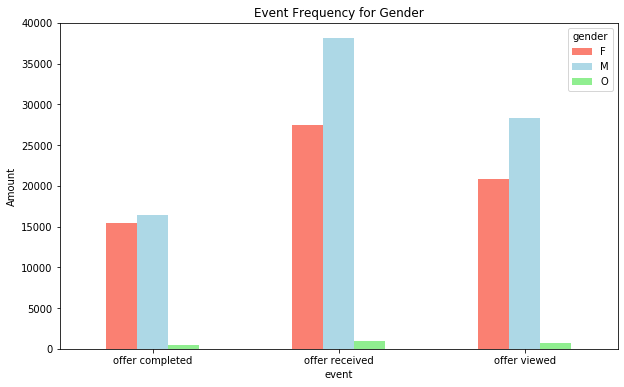

In [47]:
pd.crosstab(df.event, df.gender).plot(kind="bar", figsize=(10,6), color=["salmon", "lightblue", 'lightgreen'])

plt.title("Event Frequency for Gender")
plt.ylabel("Amount")
plt.xticks(rotation=0); # keep the labels on the x-axis vertical

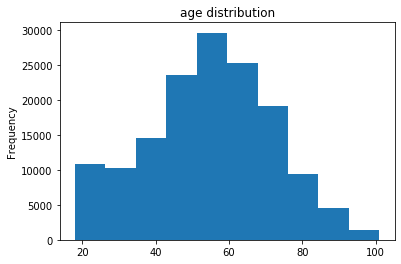

In [48]:
df.age.plot.hist(title="age distribution");

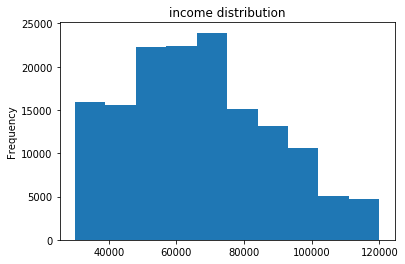

In [49]:
df.income.plot.hist(title='income distribution');

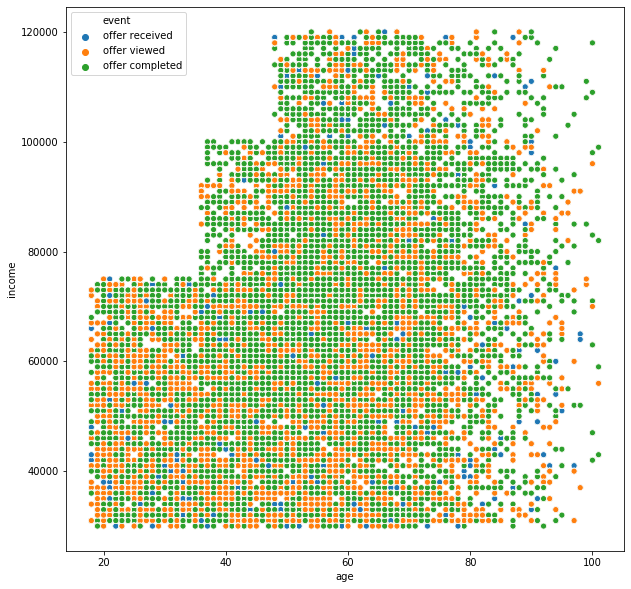

In [50]:
import seaborn as sns # seaborn gets shortened to sns

f, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=df, x="age", y="income", hue="event", ax=ax)

In [51]:
pd.crosstab(df.event,df.difficulty, normalize=True)

difficulty,0,5,7,10,20
event,,,,,
offer completed,0.000000,0.055717,0.032835,0.106724,0.022755
offer received,0.089379,0.089117,0.044723,0.178482,0.045200
offer viewed,0.062901,0.065918,0.042868,0.148496,0.014885


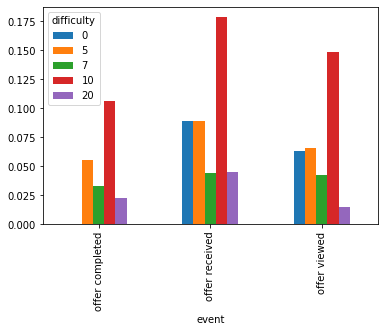

In [52]:
pd.crosstab(df.event,df.difficulty, normalize=True).plot.bar();

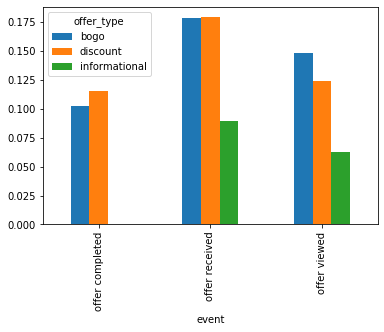

In [53]:
pd.crosstab(df.event,df.offer_type, normalize=True).plot.bar();

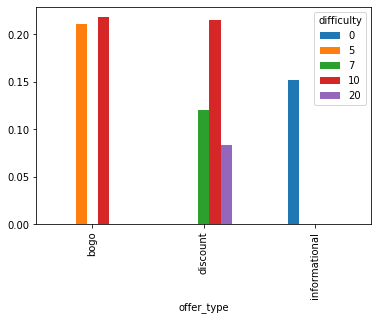

In [54]:
# seems like we should drop the informational offer type
pd.crosstab(df.difficulty,df.offer_type, normalize=True).T.plot.bar();

In [55]:
df.drop(df[df.offer_type == 'informational'].index, inplace=True)
df['offer_type'].unique()

array(['bogo', 'discount'], dtype=object)

In [56]:
df.dtypes

customer id          object
event                object
value                object
time                  int64
gender               object
age                   int64
became_member_on      int64
income              float64
reward                int64
channels             object
difficulty            int64
duration              int64
offer_type           object
dtype: object

In [57]:
df['became_member_on'] = pd.to_datetime(df['became_member_on'],  format='%Y%m%d') #converts this to date time object in ns
df['became_member_on'] = df['became_member_on'].apply(lambda x: x.value/(10**9)) #representing the number of seconds elapsed from 1970-01-01 00:00:00

In [58]:
df.head()

,customer id,event,value,time,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,F,75,1.494288e+09,100000.0,5,"['web', 'email', 'mobile']",5,7,bogo
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,9b98b8c7a33c4b65b9aebfe6a799e6d9,6,F,75,1.494288e+09,100000.0,5,"['web', 'email', 'mobile']",5,7,bogo
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,9b98b8c7a33c4b65b9aebfe6a799e6d9,132,F,75,1.494288e+09,100000.0,5,"['web', 'email', 'mobile']",5,7,bogo
3,e2127556f4f64592b11af22de27a7932,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,408,M,68,1.524701e+09,70000.0,5,"['web', 'email', 'mobile']",5,7,bogo
4,e2127556f4f64592b11af22de27a7932,offer viewed,9b98b8c7a33c4b65b9aebfe6a799e6d9,420,M,68,1.524701e+09,70000.0,5,"['web', 'email', 'mobile']",5,7,bogo


In [59]:
df.dtypes

customer id          object
event                object
value                object
time                  int64
gender               object
age                   int64
became_member_on    float64
income              float64
reward                int64
channels             object
difficulty            int64
duration              int64
offer_type           object
dtype: object

In [60]:
for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

customer id
event
value
gender
channels
offer_type


In [61]:
df["event"].unique()
event_mapping_dict = {'offer received': 0, 
          'offer viewed': 1,
          'offer completed': 2}
df["event"].replace(event_mapping_dict, inplace=True)
df.head()

,customer id,event,value,time,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,F,75,1.494288e+09,100000.0,5,"['web', 'email', 'mobile']",5,7,bogo
1,78afa995795e4d85b5d9ceeca43f5fef,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,6,F,75,1.494288e+09,100000.0,5,"['web', 'email', 'mobile']",5,7,bogo
2,78afa995795e4d85b5d9ceeca43f5fef,2,9b98b8c7a33c4b65b9aebfe6a799e6d9,132,F,75,1.494288e+09,100000.0,5,"['web', 'email', 'mobile']",5,7,bogo
3,e2127556f4f64592b11af22de27a7932,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,408,M,68,1.524701e+09,70000.0,5,"['web', 'email', 'mobile']",5,7,bogo
4,e2127556f4f64592b11af22de27a7932,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,420,M,68,1.524701e+09,70000.0,5,"['web', 'email', 'mobile']",5,7,bogo


In [62]:
gender_mapping_dict = {'M': 0, 
          'F': 1,
          'O': 2}
df["gender"].replace(gender_mapping_dict, inplace=True)
df.head()

,customer id,event,value,time,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,75,1.494288e+09,100000.0,5,"['web', 'email', 'mobile']",5,7,bogo
1,78afa995795e4d85b5d9ceeca43f5fef,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,6,1,75,1.494288e+09,100000.0,5,"['web', 'email', 'mobile']",5,7,bogo
2,78afa995795e4d85b5d9ceeca43f5fef,2,9b98b8c7a33c4b65b9aebfe6a799e6d9,132,1,75,1.494288e+09,100000.0,5,"['web', 'email', 'mobile']",5,7,bogo
3,e2127556f4f64592b11af22de27a7932,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,408,0,68,1.524701e+09,70000.0,5,"['web', 'email', 'mobile']",5,7,bogo
4,e2127556f4f64592b11af22de27a7932,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,420,0,68,1.524701e+09,70000.0,5,"['web', 'email', 'mobile']",5,7,bogo


In [63]:
#using ordinaryencoder for customer id, gender, value

**Correlation between independent variables**

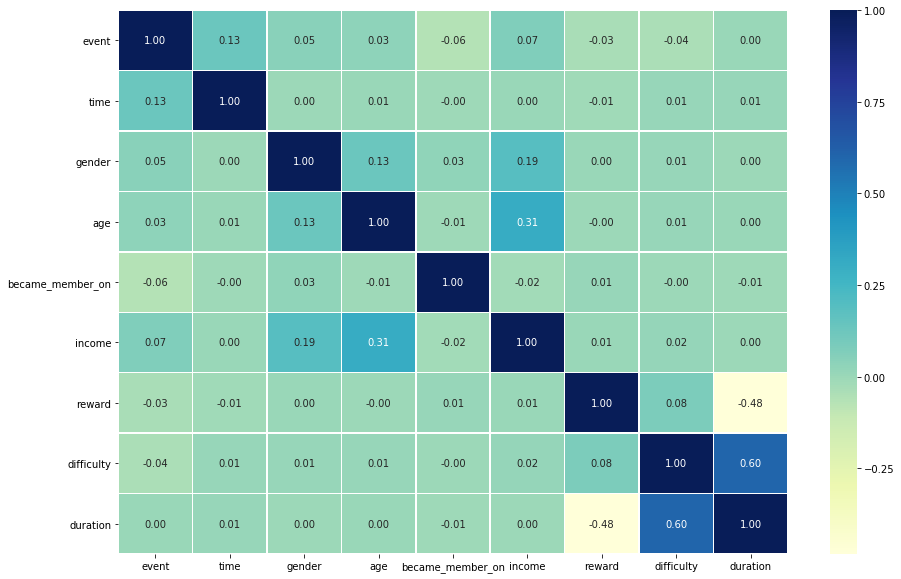

In [64]:
import seaborn as sns
corr_matrix = df.corr()
corr_matrix
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu");

In [65]:
# we might not be able to get a good model for this but we can try

**Time to start modeling**

first we need to make sure all of our data is numerical
we will use either Ordinal or One-Hot Encodings

(i could change gender, event, value, and offer type using a dictionary)<br>
i did these using my own dict:<br>
event # ordinary encoder / label encoder<br>
gender # ordinary encoder<br>

lets do the others using:<br>
customer id # ordinary encoder, if I <br>
value # one hot<br>
channels # use one hot<br>
offer_type #use one hot<br>

In [66]:
# first lets split the data in training and testing data
from sklearn.model_selection import train_test_split

np.random.seed(7)

X = df.drop("event", axis=1)
y = df["event"]

# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2)

In [67]:
len(X_train), len(X_test), len(y_train), len(y_test)

(100916, 25229, 100916, 25229)

In [68]:
X_train

,customer id,value,time,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
51274,654aba7621fe44dd8c498b75c5229b5d,f19421c1d4aa40978ebb69ca19b0e20d,384,0,49,1.452038e+09,47000.0,5,"['web', 'email', 'mobile', 'social']",5,5,bogo
135669,9b0b6a79feaa489482974734269b57bc,4d5c57ea9a6940dd891ad53e9dbe8da0,48,0,48,1.519430e+09,71000.0,10,"['web', 'email', 'mobile', 'social']",10,5,bogo
158918,95e0cad7dc6d4c8cbeb09629d9c1b6b7,2298d6c36e964ae4a3e7e9706d1fb8c2,168,1,70,1.468109e+09,57000.0,3,"['web', 'email', 'mobile', 'social']",7,7,discount
69131,4e6458c5eade4beb9b1f7d16dd8decae,0b1e1539f2cc45b7b9fa7c272da2e1d7,282,0,54,1.473898e+09,88000.0,5,"['web', 'email']",20,10,discount
102542,e4e8d867b1b8442d9a3f08929699ae50,2906b810c7d4411798c6938adc9daaa5,168,0,42,1.502582e+09,50000.0,2,"['web', 'email', 'mobile']",10,7,discount
...,...,...,...,...,...,...,...,...,...,...,...,...
142688,9aa5671757c044018bb4aac4795aa9ae,4d5c57ea9a6940dd891ad53e9dbe8da0,348,0,77,1.436141e+09,79000.0,10,"['web', 'email', 'mobile', 'social']",10,5,bogo
12122,5c73c99208e449129397591e045e641f,9b98b8c7a33c4b65b9aebfe6a799e6d9,348,0,65,1.513555e+09,36000.0,5,"['web', 'email', 'mobile']",5,7,bogo
70037,02b5aa5725f94bcb94ca58208015b7bc,0b1e1539f2cc45b7b9fa7c272da2e1d7,576,0,65,1.477613e+09,46000.0,5,"['web', 'email']",20,10,discount
79901,94aad22681a345be8106c8924f30173c,0b1e1539f2cc45b7b9fa7c272da2e1d7,168,0,63,1.419293e+09,54000.0,5,"['web', 'email']",20,10,discount


In [69]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

np.random.seed(7)

#transorming the data
hot_cat_features = ["channels", "offer_type"]
ord_cat_features=["value", "customer id"]

transformer = ColumnTransformer(transformers=[("one_hot", OneHotEncoder(), hot_cat_features), 
                                ("ord", OrdinalEncoder(), ord_cat_features)],
                                   remainder="passthrough")

transformed_X_train = transformer.fit_transform(X_train)
transformed_X_test = transformer.fit_transform(X_test)

transformed_X_train

array([[ 0.,  1.,  0., ...,  5.,  5.,  5.],
       [ 0.,  1.,  0., ..., 10., 10.,  5.],
       [ 0.,  1.,  0., ...,  3.,  7.,  7.],
       ...,
       [ 0.,  0.,  0., ...,  5., 20., 10.],
       [ 0.,  0.,  0., ...,  5., 20., 10.],
       [ 0.,  0.,  1., ...,  2., 10.,  7.]])

Now that our data is in numbers we will be trying different models to see how they compare before we fine tune them.<br>
because we are doing categorical classification using more than 100k data points we will use:
1. Stochastic Gradient Descent (SGD)
if that does not work alright we will try a different model. It is recommended to scale our data.

In [70]:
from sklearn.preprocessing import StandardScaler

np.random.seed(7)

scaler = StandardScaler()
scaler.fit(transformed_X_train)  #fit only on training data

scaled_X_train = scaler.transform(transformed_X_train)
scaled_X_test = scaler.transform(transformed_X_test)  # apply same transformation to test data

In [71]:
from sklearn.linear_model import SGDClassifier

np.random.seed(7)

clf = SGDClassifier()
clf.fit(scaled_X_train, y_train)


# Make a list to keep model scores
model_scores = {}

model_scores["SGDClassifier"] = clf.score(scaled_X_test, y_test)
print(model_scores)

{'SGDClassifier': 0.42245035475048553}


In [72]:
# thats much worse than simply flipping a coin would be

lets try different classifiers (even though we have a larger data set lets hope its fine) <br>
lets try:
2. LinearSVC
3. KNeighborsClassifier
4. RandomForestClassifier

In [73]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Lets try them all at once!
models = {"LinearSVC": LinearSVC(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier()}
np.random.seed(7)


# Loop through models
for name, model in models.items():
    # Fit the model to the data
    model.fit(transformed_X_train, y_train)
    
    # Evaluate the model and append its score to model_scores
    model_scores[name] = model.score(transformed_X_test, y_test)
print(model_scores)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'SGDClassifier': 0.42245035475048553, 'LinearSVC': 0.3037377620991716, 'KNN': 0.2509017400610409, 'Random Forest': 0.49558048277775574}


Theyre all still so bad. lets try one more:
5. LogisticRegression()

In [74]:
from sklearn.linear_model import LogisticRegression

np.random.seed(7)

clf2 = LogisticRegression()
clf2.fit(transformed_X_train, y_train)

model_scores["LogisticRegression"] = clf2.score(scaled_X_test, y_test)
print(model_scores)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


{'SGDClassifier': 0.42245035475048553, 'LinearSVC': 0.3037377620991716, 'KNN': 0.2509017400610409, 'Random Forest': 0.49558048277775574, 'LogisticRegression': 0.3842007213920488}


In [75]:
# Lets try to fine tune random forest and sgd classifiers

clf.get_params

<bound method BaseEstimator.get_params of SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)>

In the user guide tips they say:<br>
Finding a reasonable regularization term alpha is best done using automatic hyper-parameter search, e.g. GridSearchCV or RandomizedSearchCV, usually in the range 10.0 ** -np.arange(1,7).
<br>
Empirically, we found that SGD converges after observing approximately 10^6 training samples. Thus, a reasonable first guess for the number of iterations is max_iter = np.ceil(10 ** 6 / n), where n is the size of the training set.
<br>
If you apply SGD to features extracted using PCA we found that it is often wise to scale the feature values by some constant c such that the average L2 norm of the training data equals one.

In [76]:
# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": [100, 500, 1000],
           "max_depth": [None, 3, 10],
           "min_samples_split": [2,10,20],
           "min_samples_leaf": [1,10, 20]}


# Different SGD hyperparameters
sgd_grid = {'alpha': 10.0**-np.arange(1,7),
            'loss': ['hinge', 'log'],
}

In [77]:
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(7)

# Setup random hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit random hyperparameter search model
rs_rf.fit(transformed_X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 68.6min finished


In [78]:
print(rs_rf.best_params_)
rs_rf.score(transformed_X_test, y_test)

{'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_depth': None}


0.6269768916722819

In [79]:
np.random.seed(7)

# Setup random hyperparameter search for RandomForestClassifier
rs_sgd = RandomizedSearchCV(SGDClassifier(),
                           param_distributions=sgd_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit random hyperparameter search model
rs_sgd.fit(scaled_X_train, y_train);

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.5min finished


In [80]:
print(rs_sgd.best_params_)
rs_sgd.score(scaled_X_test, y_test)

{'loss': 'log', 'alpha': 0.1}


0.42879226287209166

In [81]:
# our random forest classifier did much better than before and much better than the SGDClassifier

**Evaluating the classification model, beyond accuracy**

In [82]:
y_preds = rs_rf.predict(transformed_X_test)

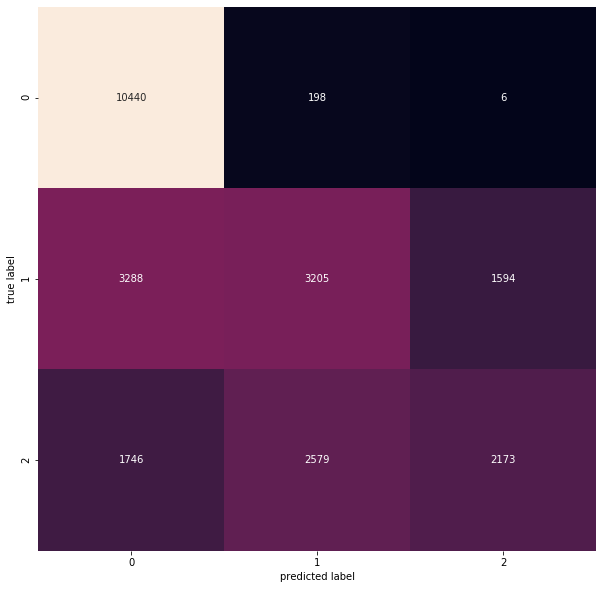

In [83]:
from sklearn.metrics import confusion_matrix, classification_report
fig,ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(confusion_matrix(y_test,y_preds),
                    annot=True,
                    cbar=False,
                    fmt='g')
plt.xlabel("predicted label")
plt.ylabel("true label");

In [84]:
confusion_matrix(y_test,y_preds)

array([[10440,   198,     6],
       [ 3288,  3205,  1594],
       [ 1746,  2579,  2173]])

In [85]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.67      0.98      0.80     10644
           1       0.54      0.40      0.46      8087
           2       0.58      0.33      0.42      6498

    accuracy                           0.63     25229
   macro avg       0.60      0.57      0.56     25229
weighted avg       0.60      0.63      0.59     25229



In [86]:
# find important features
clf = RandomForestClassifier(n_estimators= 1000, 
                             min_samples_split = 2,
                             min_samples_leaf = 20, 
                             max_depth = None)

In [87]:
clf.fit(transformed_X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [88]:
features_dict = dict(zip(X_test.columns, list(clf.feature_importances_)))
features_dict

{'customer id': 0.0024357316515823376,
 'value': 0.014348004393535703,
 'time': 0.009122732940045461,
 'gender': 0.005498410131118913,
 'age': 0.0017541736488823428,
 'became_member_on': 0.0017619913709705796,
 'income': 0.011479958547415901,
 'reward': 0.05452950112948139,
 'channels': 0.6825056983898163,
 'difficulty': 0.009778897483399432,
 'duration': 0.04842372525852037,
 'offer_type': 0.08013883013526786}

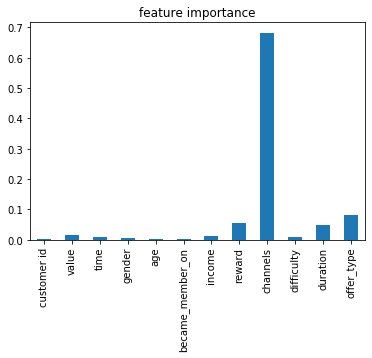

In [89]:
features_df = pd.DataFrame(features_dict, index=[0])
features_df.T.plot.bar(title="feature importance", legend=False);

Since we are still only slightly better than a coin toss we will have to make some changes. Still overall we are able to slightly better understand what is driving consumers to use their coupons. it seems like the channels are what matters when it comes to it. Still our model is not super accurate so we should fine tune it before we trust these results.

In [90]:
pd.crosstab(df.channels,df.event)

event,0,1,2
channels,,,
"['email', 'mobile', 'social']",6683,5901,3657
"['web', 'email', 'mobile', 'social']",26476,25425,17302
"['web', 'email', 'mobile']",13316,6959,8099
"['web', 'email']",6726,2215,3386


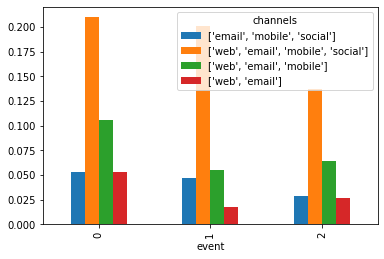

In [94]:
pd.crosstab(df.channels,df.event, normalize=True).T.plot.bar()

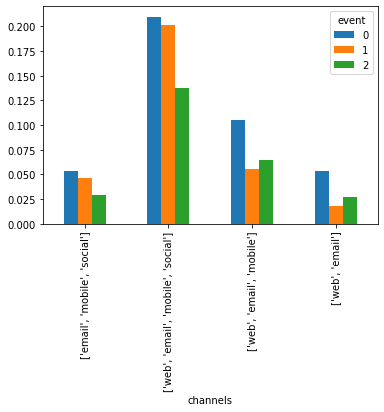

In [96]:
pd.crosstab(df.channels,df.event, normalize=True).plot.bar();